In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('/content/drive/MyDrive/6962 final project/data/final_csv_with_features.csv')

In [30]:
df = df.drop(columns='Unnamed: 0')

In [31]:
df.head()

,time,lat,lon,precip,target_label,veg,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,avg_1_3,avg_5_6,7day_avg,1month_avg,2month_avg,3month_avg
0,2000-05-31,-34,18,6.973125,0,2783.154098,2.955000,2.919375,0.217500,6.080625,4.072500,1.171875,3.123750,23.443125,19.336874,5.758125,0.695625,0.481875,0.215625,0.026250,2.030625,2.622187,2.934375,2.817937,1.425406,0.959792
1,2000-06-01,-34,18,15.020625,0,2783.154098,6.973125,2.955000,2.919375,0.217500,6.080625,4.072500,1.171875,3.123750,23.443125,19.336874,5.758125,0.695625,0.481875,0.215625,4.282500,5.076562,3.484286,3.049187,1.541625,1.037271
2,2000-06-02,-34,18,1.725000,0,2783.154098,15.020625,6.973125,2.955000,2.919375,0.217500,6.080625,4.072500,1.171875,3.123750,23.443125,19.336874,5.758125,0.695625,0.481875,8.316250,3.149062,5.462679,3.347937,1.791969,1.203583
3,2000-06-03,-34,18,2.235000,0,2783.154098,1.725000,15.020625,6.973125,2.955000,2.919375,0.217500,6.080625,4.072500,1.171875,3.123750,23.443125,19.336874,5.758125,0.695625,7.906250,1.568437,5.127321,3.397125,1.819844,1.222396
4,2000-06-04,-34,18,2.100000,0,2783.154098,2.235000,1.725000,15.020625,6.973125,2.955000,2.919375,0.217500,6.080625,4.072500,1.171875,3.123750,23.443125,19.336874,5.758125,6.326875,2.937188,4.577946,3.454937,1.857094,1.247167


In [32]:
df_models = df.copy()
df_models['cor'] = df_models.apply(lambda x: (x['lat'],x['lon']),axis = 1)
df_models['time'] = pd.to_datetime(df_models['time'])

#Plot

In [33]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler

#Select a location
sample_df = df_models.loc[ df_models['cor'] == (29, 69) ] 
sample_df['precip'] = StandardScaler().fit_transform(np.array(sample_df[['precip']]))

# Create figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=list(sample_df.loc[sample_df['target_label'] != 0].time - timedelta(days=0)), 
               y=list(sample_df.loc[sample_df['target_label'] != 0].target_label), 
               mode='markers',line=dict(color='rgb(255,0,0)'),
               name = 'CCHF Alert'
               )
    )

fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='crimson',range = [-4,4],secondary_y=False)
fig.add_trace(
    go.Scatter(x=list(sample_df.time), y=list(sample_df['3month_avg']),
               line=dict(color='rgb(0,0,255)'),
              name = 'Precipitation'
              ),
    secondary_y=True
    )
# fig.add_trace(
  # go.Scatter(x=list(sample_df.time), y=list(sample_df.target_label)))

# Set title
fig.update_layout(
    title_text="Precipitation Plot - 3 month average"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
df_models.columns

Index(['time', 'lat', 'lon', 'precip', 'target_label', 'veg', 'p_1', 'p_2',
       'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10', 'p_11', 'p_12',
       'p_13', 'p_14', 'avg_1_3', 'avg_5_6', '7day_avg', '1month_avg',
       '2month_avg', '3month_avg', 'cor'],
      dtype='object')

# More Feature

Add Lags


In [35]:
# 3 month lag
df_models = df_models.sort_values(by = ['lat','lon','time'])
df_models['monthly_avg_lagged_3_month'] = df_models['1month_avg'].shift(+90)
df_models['3-month_avg_lagged_3_month'] = df_models['3month_avg'].shift(+90)
df_models['1-month_avg_lagged_1_year'] = df_models['1month_avg'].shift(+365)
min_date = min(df_models.time)

for i in range(1,91):
  df_models = df_models.loc[-df_models['time'].isin([(min_date + timedelta(days = i)) for i in range(0,366) ])]


In [36]:
df_models.reset_index(inplace=True,drop=True)

#Logistic Regression

In [37]:
df_logi = df_models.copy()

In [38]:
df_logi

,time,lat,lon,precip,target_label,veg,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,p_12,p_13,p_14,avg_1_3,avg_5_6,7day_avg,1month_avg,2month_avg,3month_avg,cor,monthly_avg_lagged_3_month,3-month_avg_lagged_3_month,1-month_avg_lagged_1_year
0,2001-06-01,-34,18,16.605000,0,2755.366013,5.038125,0.256875,0.013125,0.015000,0.026250,0.495000,0.326250,4.43250,8.74125,2.135625,0.011250,0.000000,0.011250,0.000000,1.769375,0.260625,0.881518,1.368500,1.037937,1.148021,"(-34, 18)",0.510187,0.275521,3.049187
1,2001-06-02,-34,18,1.809375,0,2755.366013,16.605000,5.038125,0.256875,0.013125,0.015000,0.026250,0.495000,0.32625,4.43250,8.741250,2.135625,0.011250,0.000000,0.011250,7.300000,0.020625,3.207054,1.918125,1.314687,0.879292,"(-34, 18)",1.869750,0.728729,3.347937
2,2001-06-03,-34,18,6.663750,0,2755.366013,1.809375,16.605000,5.038125,0.256875,0.013125,0.015000,0.026250,0.49500,0.32625,4.432500,8.741250,2.135625,0.011250,0.000000,7.817500,0.014063,3.394821,1.961375,1.336344,0.899396,"(-34, 18)",1.868688,0.728708,3.397125
3,2001-06-04,-34,18,7.908750,0,2755.366013,6.663750,1.809375,16.605000,5.038125,0.256875,0.013125,0.015000,0.02625,0.49500,0.326250,4.432500,8.741250,2.135625,0.011250,8.359375,0.135000,4.343036,2.182125,1.446594,0.973437,"(-34, 18)",1.868625,0.728708,3.454937
4,2001-06-05,-34,18,2.405625,0,2755.366013,7.908750,6.663750,1.809375,16.605000,5.038125,0.256875,0.013125,0.01500,0.02625,0.495000,0.326250,4.432500,8.741250,2.135625,5.460625,2.647500,5.470714,2.431250,1.578406,1.061312,"(-34, 18)",1.868625,0.728708,3.439750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909587,2019-12-27,49,43,0.684375,0,3646.470000,0.000000,0.000000,0.050625,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,6.871875,0.000000,0.000000,4.218750,0.000000,0.016875,0.000000,0.007232,1.102688,1.526656,2.969875,"(49, 43)",4.208875,3.176813,0.857687
909588,2019-12-28,49,43,0.000000,0,3646.470000,0.684375,0.000000,0.000000,0.050625,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,6.871875,0.000000,0.000000,4.218750,0.228125,0.000000,0.105000,1.125438,1.538063,2.977479,"(49, 43)",4.061437,3.176813,0.823375
909589,2019-12-29,49,43,0.000000,0,3646.470000,0.000000,0.684375,0.000000,0.000000,0.050625,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,6.871875,0.000000,0.000000,0.228125,0.025313,0.105000,1.125438,1.490375,2.977375,"(49, 43)",4.015625,3.164271,0.838375
909590,2019-12-30,49,43,3.502500,0,3646.470000,0.000000,0.000000,0.684375,0.000000,0.000000,0.050625,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,6.871875,0.000000,0.228125,0.025313,0.105000,1.125438,1.490375,2.977375,"(49, 43)",3.678125,3.154188,0.838375


In [39]:
import random
random.seed(0)
alert_idx = df_logi.loc[df_logi['target_label'] != 0].index
sample_idx = random.sample(list(df_logi.loc[df_logi['target_label'] == 0].index),len(alert_idx))
idx = list(alert_idx) + sample_idx
feature = df_logi.drop(columns=['lon','lat','time', 'target_label','cor']
                       +['p_'+str(i) for i in range(1,15)])
target = df_logi['target_label']
X = feature.iloc[idx]
y = target.iloc[idx]

In [40]:
X.reset_index(inplace=True,drop=True)
y.reset_index(inplace=True,drop=True)

In [41]:
X.head()

,precip,veg,avg_1_3,avg_5_6,7day_avg,1month_avg,2month_avg,3month_avg,monthly_avg_lagged_3_month,3-month_avg_lagged_3_month,1-month_avg_lagged_1_year
0,0.000,2835.712418,0.001250,0.000000,0.001071,0.033125,0.031406,0.462333,8.491625,7.568458,0.282312
1,0.000,3476.155000,0.345000,0.002812,0.161786,4.459438,2.505281,2.694083,0.103000,0.262458,7.320187
2,0.000,3476.155000,28.941875,0.038437,12.769286,7.417812,3.914156,3.614354,0.435625,0.251625,9.645250
3,0.405,1290.665000,0.240000,0.901875,0.400446,0.319000,0.591094,0.797292,2.128250,1.508437,1.706500
4,0.000,3586.247500,0.056250,3.101250,1.171875,0.495187,1.189594,1.043250,2.688438,2.836396,1.984437


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report

# predictors = df_logi[[ 'avg_1_3', 'avg_5_6','1month_avg', '3month_avg']]
# target = df_logi['target_label']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.33, random_state = 0)
y_train = y_train.copy()
y_train[(y_train.loc[(y_train>1)]).index] = 1
print(y_train.unique())
y_test = y_test.copy()
y_test[(y_test.loc[(y_test>1)]).index] = 1
print(y_test.unique())


clf = LogisticRegression(solver='newton-cg',random_state=0).fit(X_train, y_train.astype(int))
y_pred = clf.predict(X_test).astype(int)
y_test = y_test.astype(int)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

accuracy_score(y_test, y_pred)


[0 1]
[0 1]


0.5670498084291188

In [92]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

In [93]:
tn, fp, fn, tp

(134, 127, 99, 162)

In [85]:
print(classification_report(y_test, y_pred, target_names=['class_0','class_1']))


              precision    recall  f1-score   support

     class_0       0.58      0.51      0.54       261
     class_1       0.56      0.62      0.59       261

    accuracy                           0.57       522
   macro avg       0.57      0.57      0.57       522
weighted avg       0.57      0.57      0.57       522



In [43]:
import statsmodels.api as sm
import numpy as np
y_2 = y.copy()
y_2[(y_2.loc[(y_2>1)]).index] = 1

logit_model=sm.Logit(np.asarray(y_2),X,solver='newton-cg')
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.686237
         Iterations 4
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.010    
Dependent Variable:     y                   AIC:                 2190.5080
Date:                   2021-12-08 09:44    BIC:                 2249.5250
No. Observations:       1580                Log-Likelihood:      -1084.3  
Df Model:               10                  LL-Null:             -1095.2  
Df Residuals:           1569                LLR p-value:         0.015956 
Converged:              1.0000              Scale:               1.0000   
No. Iterations:         4.0000                                            
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
precip                      

Helper Functions

In [44]:
def sort_importance(list1, list2):
  '''
  This function takes in two lists, 
  sort them in pair by list2 in descending order,
  and return the sorted lists
  '''
  list2 = list(list2.copy())
  zipped_lists = zip(list2, list1)
  sorted_pairs = sorted(zipped_lists, reverse = True)
  tuples = zip(*sorted_pairs)
  list2, list1 = [ list(tuple) for tuple in  tuples]
  return list1, list2

# Random Forest

In [45]:
list(range(1,5,1))

[1, 2, 3, 4]

In [46]:
#Grid Search for Hyper-Parameter tuning

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Number of trees in random forest
n_estimators = [int(x) for x in list(range(100,1100,100))]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in list(range(3,11,1))]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,
                               scoring='accuracy'
                               , cv = 3, verbose=2, random_state=0, n_jobs = -1,return_train_score=True)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [47]:
rf_random.cv_results_

{'mean_fit_time': array([2.61044804, 2.3065815 , 2.2482512 , 0.41041493, 2.61984571,
        0.67302752, 2.2985909 , 0.7836434 , 1.22318451, 3.59315642,
        1.55225992, 1.53421919, 3.46569157, 1.71018092, 2.58911435,
        1.06603781, 2.01890516, 1.53829161, 2.44685157, 0.73191969]),
 'mean_score_time': array([0.17737341, 0.18061034, 0.14664666, 0.03030507, 0.16935047,
        0.04729223, 0.16156038, 0.0536743 , 0.07994286, 0.26276922,
        0.10031915, 0.09922091, 0.22615647, 0.12649671, 0.19581342,
        0.07322296, 0.13132524, 0.09943167, 0.17644056, 0.05660295]),
 'mean_test_score': array([0.65218313, 0.62760484, 0.65880655, 0.6550294 , 0.65407438,
        0.65028382, 0.65879045, 0.66732123, 0.67581981, 0.66164209,
        0.65027309, 0.65596832, 0.66164478, 0.62854376, 0.62760215,
        0.64934758, 0.66446422, 0.65975084, 0.63988325, 0.65598174]),
 'mean_train_score': array([0.94139996, 0.68761712, 0.96360945, 1.        , 0.96455374,
        0.85019254, 0.80104407, 0.9

In [48]:
hps = rf_random.cv_results_['params']
hps[13]

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 600}

In [49]:
rf_random.best_score_

0.6758198128594729

In [50]:
test_acc = rf_random.cv_results_['mean_test_score']
train_acc = rf_random.cv_results_['mean_train_score']

Text(0, 0.5, 'Accuracy')

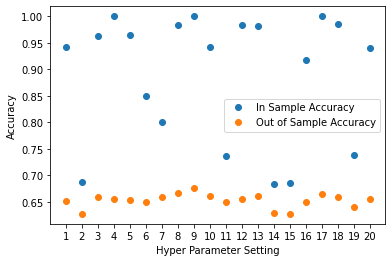

In [53]:
  plt.plot([str(i) for i in range(1,len(test_acc)+1) ],train_acc,'o' , label = "In Sample Accuracy")
  plt.plot([str(i) for i in range(1,len(test_acc)+1) ],test_acc ,'o', label = "Out of Sample Accuracy")
  leg = plt.legend(loc='best')
  plt.xlabel('Hyper Parameter Setting')
  plt.ylabel('Accuracy')

In [94]:
def my_Random_Forest(X_train, X_test, y_train, y_test):
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 600, max_depth=3, max_features= 'auto',random_state = 0)
  forest.fit(X_train, y_train)
  y_pred = forest.predict(X_test)
  print('Random Forest in-sample Accuracy:', accuracy_score(y_train, forest.predict(X_train)))
  print('Random Forest out-of-sample Accuracy:', accuracy_score(y_test, y_pred))
  forest_importance = forest.feature_importances_
  sorted_features, sorted_values = sort_importance(X_train.columns, forest_importance)
  for i in range(len(sorted_features)):
    print(sorted_features[i],':',sorted_values[i])
  print(classification_report(y_test, y_pred, target_names=['class_0','class_1']))

In [95]:
my_Random_Forest(X_train, X_test, y_train, y_test)

Random Forest in-sample Accuracy: 0.6720226843100189
Random Forest out-of-sample Accuracy: 0.6245210727969349
veg : 0.20018198118111127
1month_avg : 0.1368493341573413
3-month_avg_lagged_3_month : 0.11997121368925458
7day_avg : 0.10139461624716173
2month_avg : 0.10098653562217622
3month_avg : 0.08452552168260313
1-month_avg_lagged_1_year : 0.07698125264570793
monthly_avg_lagged_3_month : 0.06526383846506156
avg_1_3 : 0.051630959658736666
avg_5_6 : 0.04230894818120772
precip : 0.01990579846963791
              precision    recall  f1-score   support

     class_0       0.64      0.56      0.60       261
     class_1       0.61      0.69      0.65       261

    accuracy                           0.62       522
   macro avg       0.63      0.62      0.62       522
weighted avg       0.63      0.62      0.62       522



#XGBoost

In [102]:
def my_xgb(X_train, X_test, y_train, y_test):
  import xgboost as xg
  from sklearn.model_selection import KFold
  from sklearn.model_selection import cross_val_score
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X_train_std = scaler.fit_transform(X_train.copy())
  param = {"booster":"gbtree", "objective":"binary:hinge"}
  xgb_reg = xg.XGBClassifier(booster = "gbtree",objective = "binary:hinge",n_estimators = 600)
  xgb_reg.fit(X_train_std,y_train)
  # print(xgb_reg.coef_)
  y_pred = xgb_reg.predict(scaler.fit_transform(X_test.copy()))
  print('XGBoost out-of-sample Accuracy:', accuracy_score(y_test, y_pred))
  xgb_importance = xgb_reg.feature_importances_
  sorted_features, sorted_values = sort_importance(X_train.columns, xgb_importance)
  for i in range(len(sorted_features)):
    print(sorted_features[i],':',sorted_values[i])
  print(classification_report(y_test, y_pred, target_names=['class_0','class_1']))

In [103]:
my_xgb(X_train, X_test, y_train, y_test)

XGBoost out-of-sample Accuracy: 0.603448275862069
3month_avg : 0.1618659
3-month_avg_lagged_3_month : 0.12508267
1-month_avg_lagged_1_year : 0.11106187
2month_avg : 0.09870037
1month_avg : 0.09794748
veg : 0.096329406
avg_5_6 : 0.06776354
monthly_avg_lagged_3_month : 0.0671391
7day_avg : 0.063034534
avg_1_3 : 0.060382653
precip : 0.05069244
              precision    recall  f1-score   support

     class_0       0.64      0.47      0.54       261
     class_1       0.58      0.74      0.65       261

    accuracy                           0.60       522
   macro avg       0.61      0.60      0.60       522
weighted avg       0.61      0.60      0.60       522



#KNN

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [120]:
def KNN_CV(X_train, y_train):
  knn_benchmark = list()
  knn_benchmark_test = list()
  standardized_X_train = StandardScaler().fit_transform(X_train)
  standardized_X_test = StandardScaler().fit_transform(X_test)
  for i in range(1,int(np.sqrt(len(standardized_X_train))),2):
    knn_reg = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(knn_reg,standardized_X_train,y_train,cv = 5,scoring='accuracy')
    knn_benchmark.append(scores.mean())
    y_pred = knn_reg.fit(standardized_X_train,y_train).predict(standardized_X_test)
    knn_benchmark_test.append(accuracy_score(y_test, y_pred))
  best_Acc = max(knn_benchmark)
  best_k = 2*(knn_benchmark.index(best_Acc) + 1)-1
  knn_benchmark = [i for i in knn_benchmark]
  #from plot, k = 19 is the best
  
  
  plt.plot(range(1,int(np.sqrt(len(standardized_X_train))),2),knn_benchmark , label = "In Sample Accuracy")
  plt.plot(range(1,int(np.sqrt(len(standardized_X_train))),2),knn_benchmark_test , label = "Out of Sample Accuracy")
  leg = plt.legend(loc='lower left')
  plt.xlabel('K')
  plt.ylabel('Accuracy')
  print(knn_benchmark)
  print(knn_benchmark_test)
  print('k =', best_k, 'gives the highest Accuracy of', best_Acc)

[0.6389877492622732, 0.6295180184208172, 0.6191227756415989, 0.6464812662076366, 0.6332781901099884, 0.6228740051864438, 0.6181793794151839, 0.6229187159080748, 0.6200572297236878, 0.6200751140123402, 0.6143610837878923, 0.6087275328623803, 0.6134579272109452, 0.6030582133595637, 0.5973799517124206, 0.584154520253957]
[0.6417624521072797, 0.6187739463601533, 0.6264367816091954, 0.6340996168582376, 0.6379310344827587, 0.6302681992337165, 0.6398467432950191, 0.6360153256704981, 0.6379310344827587, 0.6340996168582376, 0.6436781609195402, 0.6398467432950191, 0.6455938697318008, 0.6360153256704981, 0.6206896551724138, 0.6187739463601533]
k = 7 gives the highest Accuracy of 0.6464812662076366


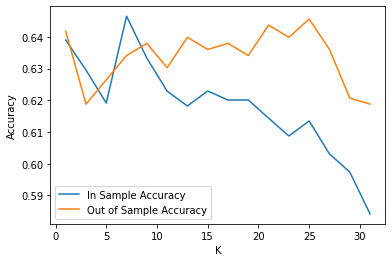

In [121]:
KNN_CV(X_train, y_train)

In [122]:
def my_KNN(X_train, X_test, y_train, y_test):
  from sklearn.preprocessing import StandardScaler
  standardized_X_train = StandardScaler().fit_transform(X_train)
  knn_reg = KNeighborsClassifier(n_neighbors = 7)
  knn_reg.fit(standardized_X_train, y_train)
  standardized_X_test = StandardScaler().fit_transform(X_test)
  y_pred = knn_reg.predict(standardized_X_test)
  print('KNN in sample Accuracy:', accuracy_score(y_train, knn_reg.predict(standardized_X_train)))
  print('KNN out of sample Accuracy:', accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred, target_names=['class_0','class_1']))

In [119]:
my_KNN(X_train, X_test, y_train, y_test)

KNN in sample Accuracy: 0.7325141776937618
KNN out of sample Accuracy: 0.6379310344827587
              precision    recall  f1-score   support

     class_0       0.65      0.60      0.62       261
     class_1       0.63      0.68      0.65       261

    accuracy                           0.64       522
   macro avg       0.64      0.64      0.64       522
weighted avg       0.64      0.64      0.64       522



#Naive Sequential Neural Network

In [75]:
def my_neural_network(X_train, X_test, y_train, y_test):
  import tensorflow as tf
  import keras
  from keras.models import Sequential
  from keras.layers import Dense
  from sklearn.preprocessing import StandardScaler

  standardized_X_train = StandardScaler().fit_transform(X_train)
  standardized_X_test = StandardScaler().fit_transform(X_test)
  my_neural_net = Sequential()

  my_neural_net.add(tf.keras.layers.Dropout(.3, input_shape=(len(X_train.columns),),name = 'Dropout'))
  my_neural_net.add(Dense(64, activation='relu',kernel_initializer='normal', input_shape=(len(X_train.columns),),name = 'Dense1'))
  my_neural_net.add(Dense(32, activation='relu',name = 'Dense2'))
  my_neural_net.add(Dense(16, activation='relu',name = 'Dense3'))
  my_neural_net.add(Dense(1, activation='sigmoid',name = 'Activation'),)

  my_neural_net.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  # early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=0.0001 , patience=5)
  history = my_neural_net.fit(standardized_X_train, y_train,epochs=100,callbacks=[],
                    batch_size=16, verbose = 2,
                    validation_data=(standardized_X_test, y_test))
  # predict_x=my_neural_net.predict(standardized_X_test) 
  # y_pred=np.argmax(predict_x,axis=1)
  my_neural_net.summary()
  print('Neural Net in-sample Accuracy:', np.mean(history.history['accuracy'][0:50]))
  print('Neural Net out-of-sample Accuracy:', max(history.history['val_accuracy'][0:50]))
  plt.plot(range(1,101), history.history['accuracy'] , label = "In Sample Accuracy")
  plt.plot(range(1,101), history.history['val_accuracy'], label = "Out of Sample Accuracy")
  leg = plt.legend(loc='upper left')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

Epoch 1/100
67/67 - 1s - loss: 0.6825 - accuracy: 0.5302 - val_loss: 0.6874 - val_accuracy: 0.5536 - 1s/epoch - 16ms/step
Epoch 2/100
67/67 - 0s - loss: 0.6781 - accuracy: 0.5718 - val_loss: 0.6827 - val_accuracy: 0.5556 - 197ms/epoch - 3ms/step
Epoch 3/100
67/67 - 0s - loss: 0.6766 - accuracy: 0.5699 - val_loss: 0.6773 - val_accuracy: 0.5690 - 168ms/epoch - 3ms/step
Epoch 4/100
67/67 - 0s - loss: 0.6719 - accuracy: 0.5870 - val_loss: 0.6773 - val_accuracy: 0.5690 - 180ms/epoch - 3ms/step
Epoch 5/100
67/67 - 0s - loss: 0.6704 - accuracy: 0.5813 - val_loss: 0.6748 - val_accuracy: 0.5843 - 165ms/epoch - 2ms/step
Epoch 6/100
67/67 - 0s - loss: 0.6680 - accuracy: 0.5955 - val_loss: 0.6799 - val_accuracy: 0.5709 - 175ms/epoch - 3ms/step
Epoch 7/100
67/67 - 0s - loss: 0.6654 - accuracy: 0.5879 - val_loss: 0.6715 - val_accuracy: 0.5747 - 199ms/epoch - 3ms/step
Epoch 8/100
67/67 - 0s - loss: 0.6732 - accuracy: 0.5595 - val_loss: 0.6733 - val_accuracy: 0.5862 - 158ms/epoch - 2ms/step
Epoch 9/10

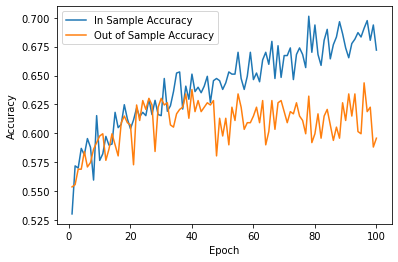

In [76]:
my_neural_network(X_train, X_test, y_train, y_test)